# Tutorial: Markov Chain Monte Carlo With Turing.jl

## Overview

This tutorial will give some examples of using `Turing.jl` and Markov
Chain Monte Carlo to sample from posterior distributions.

## Setup

In [2]:
using Turing
using Distributions
using Plots
using LaTeXStrings
using StatsPlots
using StatsBase
using Optim
using Random
using DataFrames
using Downloads
using CSV

As this tutorial involves random number generation, we will set a random
seed to ensure reproducibility.

In [3]:
Random.seed!(1);

## Fitting A Linear Regression Model

Let’s start with a simple example: fitting a linear regression model to
simulated data.

> **Positive Control Tests**
>
> Simulating data with a known data-generating process and then trying
> to obtain the parameters for that process is an important step in any
> workflow.

### Simulating Data

The data-generating process for this example will be: $$
\begin{gather}
y = 5 + 4x + \varepsilon \\
\varepsilon \sim \text{Normal}(0, 10),
\end{gather}
$$ where $\varepsilon$ is so-called “white noise”, which adds
stochasticity to the data set. The generated dataset is shown in
[Figure 1](#fig-scatter-regression).

In [4]:
# create trend for data
x = rand(Uniform(0, 20), 10)
y = 5 .+ 4 * x
# sample and add noise
ε = rand(Normal(0, 10), 10)
y .+= ε

scatter(x, y, label="Data", xlabel=L"$x$", ylabel=L"$y$", markersize=10, tickfontsize=14, guidefontsize=16, legendfontsize=16)

### Model Specification

The statistical model for a standard linear regression problem is $$
\begin{gather}
y = a + bx + \varepsilon \\
\varepsilon \sim \text{Normal}(0, \sigma^2).
\end{gather}
$$

Rearranging, we can rewrite the likelihood function as:
$$y \sim \text{Normal}(\mu, \sigma^2),$$ where $\mu = a + bx$. This
means that we have three parameters to fit: $a$, $b$, and $\sigma^2$.

Next, we need to select priors on our parameters. We’ll use relatively
generic distributions to avoid using the information we have (since we
generated the data ourselves), but in practice, we’d want to use any
relevant information that we had from our knowledge of the problem.
Let’s use relatively diffuse normal distributions for the trend
parameters $a$ and $b$ and a half-normal distribution (a normal
distribution truncated at 0, to only allow positive values) for the
variance $\sigma^2$, as recommended by [Gelman
(2006)](https://doi.org/10.1214/06-BA117A).

$$
\begin{gather}
a \sim \text{Normal(0, 10)} \\
b \sim \text{Normal(0, 10)} \\
\sigma^2 \sim \text{Half-Normal}(0, 25)
\end{gather}
$$

### Using Turing

#### Coding the Model

`Turing.jl` uses the `@model` macro to specify the model function. We’ll
follow the setup in the [Turing
documentation](https://turinglang.org/dev/tutorials/05-linear-regression).

To specify distributions on parameters (and the data, which can be
thought of as uncertain parameters in Bayesian statistics), use a tilde
`~`, and use equals `=` for transformations (which we don’t have in this
case).

In [5]:
@model function linear_regression(x, y)
    # set priors
    σ² ~ truncated(Normal(0, 25); lower=0)
    a ~ Normal(0, 10)
    b ~ Normal(0, 10)

    # we can specify the likelihood with a loop, as our data is i.i.d.
    # we could also rewrite this using linear algebra, which might be more efficient for large and/or complex models or datasets, but this will be more readable in this simple case.
    for i = 1:length(y)
        # compute the mean value for the data point
        μ = a + b * x[i]
        y[i] ~ Normal(μ, σ²)
    end
end

linear_regression (generic function with 2 methods)

#### Fitting The Model

Now we can call the sampler to draw from the posterior. We’ll use the
[No-U-Turn
sampler](http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf),
which is a Hamiltonian Monte Carlo algorithm (a different category of
MCMC sampler than the Metropolis-Hastings algorithm discussed in class).
We’ll also use 4 chains so we can test that the chains are well-mixed,
and each chain will be run for 5,000 iterations[1]

[1] Hamiltonian Monte Carlo samplers often need to be run for fewer
iterations than Metropolis-Hastings samplers, as the exploratory step
uses information about the gradient of the statistical model, versus the
random walk of Metropolis-Hastings. The disadvantage is that this
gradient information must be available, which is not always the case for
simulation models.

In [6]:
chain = let
    model = linear_regression(x, y) # create the model object with the data
    sampler = NUTS()
    n_per_chain = 5000
    nchains = 4
    # call the sampler and drop the "burn-in/warm-up" portion
    sample(model, sampler, MCMCThreads(), n_per_chain, nchains, drop_warmup=true);
end

@show chain

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC ~/.julia/packages/AbstractMCMC/F9Hbk/src/sample.jl:296

┌ Info: Found initial step size
└   ϵ = 0.00625
┌ Info: Found initial step size
└   ϵ = 0.05

┌ Info: Found initial step size
└   ϵ = 0.003125
┌ Info: Found initial step size
└   ϵ = 0.0125

Sampling (1 threads):  50%|██████████████▌              |  ETA: 0:00:00

Sampling (1 threads): 100%|█████████████████████████████| Time: 0:00:01

chain = MCMC chain (5000×15×4 Array{Float64, 3})

Chains MCMC chain (5000×15×4 Array{Float64, 3}):
Iterations = 1001:1:6000
Number of chains = 4
Samples per chain = 5000
Wall duration = 15.89 seconds
Compute duration = 13.32 seconds
parameters = σ², a, b
internals = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size
Summary Statistics
 parameters mean std naive_se mcse ess rhat ⋯
 Symbol Float64 Float64 Float64 Float64 Float64 Float64 ⋯
 σ² 9.9355 2.8951 0.0205 0.0329 8133.9030 1.0008 ⋯
 a 3.0112 4.7115 0.0333 0.0495 7709.7148 1.0006 ⋯
 b 3.9132 0.4540 0.0032 0.0051 7151.1739 1.0004 ⋯
 1 column omitted 
Quantiles
 parameters 2.5% 25.0% 50.0% 75.0% 97.5% 
 Symbol Float64 Float64 Float64 Float64 Float64 
 σ² 6.0219 7.9104 9.3808 11.3350 17.1375
 a -6.5339 0.0383 3.0647 6.0833 12.2396
 b 3.0253 3.6243 3.9060 4.1948 4.8241

How can we interpret the output? The first parts of the summary
statistics are straightforward: we get the mean, standard deviation, and
Monte Carlo standard error (`mcse`) of each parameter. We also get
information about the effective sample size (ESS)[1] and $\hat{R}$,
which measures the ratio of within-chain variance and across-chain
variance as a check for convergence[2].

In this case, we can see that we were able to recover the “true”
data-generating values of $\sigma^2 = 10$ and $b = 4$, but $a$ is
slightly off (the mean is 3, rather than the data-generating value of
5). This isn’t surprising: given the variance of the noise $\sigma^2$,
there are many different intercepts which could fit within that spread.

Let’s now plot the chains for visual inspection.

[1] The ESS reflects the efficiency of the sampler: this is an estimate
of the equivalent number of independent samples; the more correlated the
samples, the lower the ESS.

[2] The closer $\hat{R}$ is to 1, the better.

In [7]:
plot(chain)

We can see from [Figure 2](#fig-chains-regression) that our chains mixed
well and seem to have converged to similar distributions! The traceplots
have a “hairy caterpiller” appearance, suggesting relatively little
autocorrelation. This aligns with the ESS estimates from the `chain`
output, which are higher than the number of drawn samples[1]. We can
also see how much more uncertainty there is with the intercept $a$,
while the slope $b$ is much more constrained, with a 95% credible
interval of $(3, 4.8)$ (compared to $(-6.5, 12)$ for $a$).

Another interesting comparison we can make is with the
maximum-likelihood estimate (MLE), which we can obtain through
optimization.

[1] Which is possible with Hamiltonian Monte Carlo due to the efficiency
of exploration!

In [8]:
mle_model = linear_regression(x, y); # specify the model object
optimize(mle_model, MLE())

The MLE results have some additional error compared to the MCMC means
(the slope and noise variance are further from the data-generating
values), but this can be a lot faster, at the expense of getting
estimates of uncertainty.

### Model Diagnostics and Posterior Predictive Checks

One advantage of the Bayesian modeling approach here is that we have
access to a *generative model*, or a model which we can use to generate
datasets. This means that we can now use Monte Carlo simulation,
sampling from our posteriors, to look at how uncertainty in the
parameter estimates propagates through the model. Let’s write a function
which gets samples from the MCMC chains and generates datasets.

In [9]:
function mc_predict_regression(x, chain)
    # the Array(group()) syntax is more general than we need, but will work if we have multiple variables which were sampled as a group, for example multiple regression coefficients.
    a = Array(group(chain, :a))
    b = Array(group(chain, :b))
    σ² = Array(group(chain, :σ²))

    μ = a' .+ x * b'
    y = zeros((length(x), length(a)))
    for i = 1:length(a)
        y[:, i] = rand.(Normal.(μ[:, i], σ²[i]))
    end
    return y
end

mc_predict_regression (generic function with 1 method)

Now we can generate a predictive interval and median and compare to the
data.

In [10]:
x_pred = 0:20;
y_pred = mc_predict_regression(x_pred, chain)

21×20000 Matrix{Float64}:
   6.68936    -1.81801  -4.58763  …   14.6356    -0.671331   5.57161
   2.46789     7.18889   9.67166       6.15337   -0.285616  13.6276
 -19.928     -10.5487   15.1344       -8.11842    0.408939  -4.88305
  33.1545     20.7704   10.2623        6.02563    6.57178    7.53745
  35.2771     16.3458    8.57409      20.2317    13.3907     4.84027
  21.1928     26.1562   36.552    …   -0.179761  14.5226    15.3409
  40.7311     23.572    41.5141       31.8598    37.1869    27.9604
   0.423933   13.9711   28.51         54.575     32.9363    28.5016
  62.4813     47.5292   35.4607       37.3601    32.239     30.2444
  51.1977     27.8843   34.0011       41.9719    52.8179    46.9838
  45.2684     55.6934   37.2417   …   58.5066    45.3842    26.1518
  51.8353     38.6125   42.5691       60.4984    50.5223    37.1143
  56.3781     56.4842   72.109        70.1629    58.2065    56.5514
  73.8257     41.2734   37.0866       52.9339    41.956     50.9942
  57.176      47.6

Notice the dimension of `y_pred`: we have 20,000 columns, because we
have 4 chains with 5,000 samples each. If we had wanted to subsample
(which might be necessary if we had hundreds of thousands or millions of
samples), we could have done that within `mc_linear_regression` before
simulation.

In [11]:
# get the boundaries for the 95% prediction interval and the median
y_ci_low = quantile.(eachrow(y_pred), 0.025);
y_ci_hi = quantile.(eachrow(y_pred), 0.975);
y_med = quantile.(eachrow(y_pred), 0.5);

Now, let’s plot the prediction interval and median, and compare to the
original data.

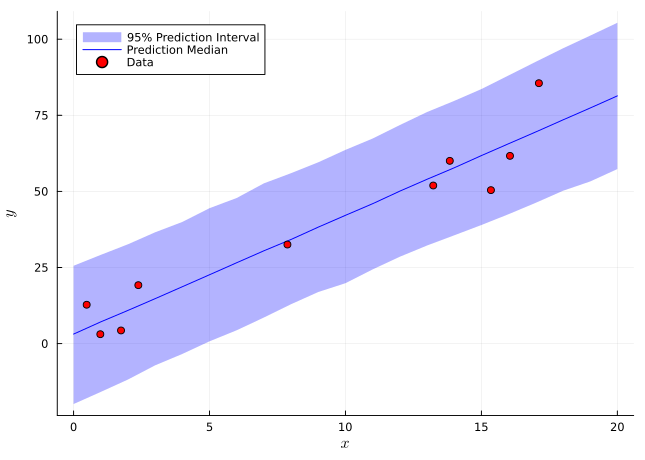

In [12]:
# plot prediction interval
plot(x_pred, y_ci_low, fillrange=y_ci_hi, xlabel=L"$x$", ylabel=L"$y$", fillalpha=0.3, fillcolor=:blue, label="95% Prediction Interval", legend=:topleft, linealpha=0)
# plot median line
plot!(x_pred, y_med, color=:blue, label="Prediction Median")
scatter!(x, y, color=:red, label="Data")

From [Figure 3](#fig-prediction-regression), it looks like our model
might be slightly under-confident, as with 10 data points, we would
expect 5% of them (or 1/2 of a “data point”) to be outside the 95%
prediction interval. It’s hard to tell with only 10 data points, though!
We could resolve this by tightening our priors, but this depends on how
much information we used to specify them in the first place. The goal
shouldn’t be to hit a specific level of uncertainty, but if there is a
sound reason to tighten the priors, we could do so.

Now let’s look at the residuals from the posterior median and the data.
The partial autocorrelations plotted in
[Figure 4](#fig-residuals-regression) are not fully convincing, as there
are large autocorrelation coefficients with long lags, but the dataset
is quite small, so it’s hard to draw strong conclusions. We won’t go
further down this rabbit hole as we know our data-generating process
involved independent noise, but for a real dataset, we might want to try
a model specification with autocorrelated data to compare.

In [13]:
y_pred_data = mc_predict_regression(x, chain)
y_med_data = quantile.(eachrow(y_pred_data), 0.5)
residuals = y_med_data .- y
plot(pacf(residuals, 1:4), line=:stem, marker=:circle, legend=:false, grid=:false, linewidth=2, xlabel="Lag", ylabel="Partial Autocorrelation", markersize=8, tickfontsize=14, guidefontsize=16, legendfontsize=16)
hline!([0], linestyle=:dot, color=:red)

## Fitting Extreme Value Models to Tide Gauge Data

Let’s now look at an example of fitting an extreme value distribution
(namely, a generalized extreme value distribution) to tide gauge data.

First, we’ll download and plot the data:

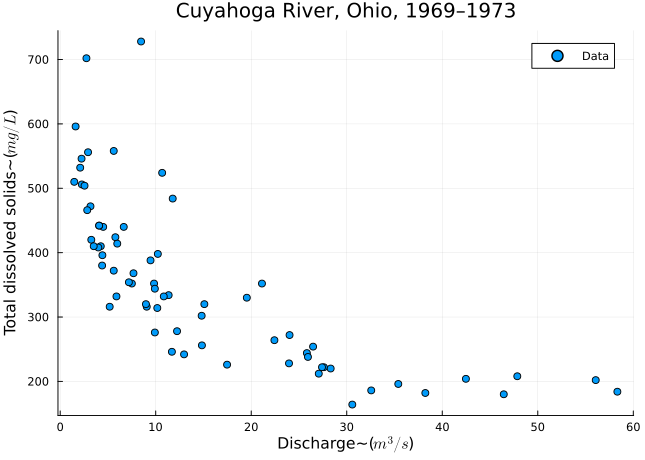

In [14]:
fname = "data/tds.csv" # CHANGE THIS!
url = "https://www.sciencebase.gov/catalog/file/get/5d5af82de4b01d82ce8ed296?f=__disk__b9%2Fb7%2F40%2Fb9b74037d91c45e730ba4c170fe3ffaf9470d360"
if !isfile(fname)
    Downloads.download(url, fname)
end
tds = DataFrame(CSV.File(fname))
tds[!, [:date, :discharge_cms, :tds_mgL]]

p = scatter(tds.discharge_cms, tds.tds_mgL, xlabel=L"Discharge~($m^3/s$)", ylabel=L"Total dissolved solids~($mg/L$)", title="Cuyahoga River, Ohio, 1969–1973", label="Data")

Note at [Figure 5](#fig-tds-scatter) does not look linear at all.
However, it does look roughly like an inverse-exponential plot, which
suggests that logarithmically-transforming the $x$-axis might look
linear.

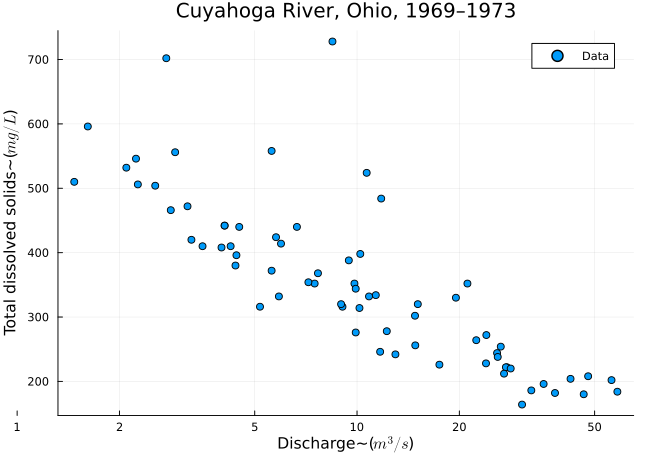

In [15]:
x_ticks = [1, 2, 5, 10, 20, 50, 100]
plot(p, xaxis=:log, xticks=(x_ticks, string.(x_ticks)))